## Microsoft Security Incident Prediction

### Introduction
In 2017, Microsoft released a groundbreaking dataset containing entries of real-world cybersecurity incidents. The dataset involved over 1 million annotated incidents with over 40 features and triage labels to denote the incident severity. The purpose of this project is to analyze this data and create an effective model for classifying how severe a particular security incident is based on the provided features. Each incident is given one of the following triage labels:

- TruePositive: Given to reported incidents corresponding to an actual attack or threat
- FalsePositive: Given to reported incidents that do not correspond to an actual attack or threat; a false report
- BenignPositive: Given to incidents correctly reported but determined to be harmless; an informational incident

Being able to precisely classify incidents into these labels is critical to addressing security incidents in a timely manner, especially at this scale. Security experts will be better equipped to prioritize certain reported incidents over others if provided with an effective classification model. This project aims to create such a model.

### The Data
The dataset can be downloaded from Kaggle, it is quite large so I avoided uploading it directly: https://www.kaggle.com/datasets/Microsoft/microsoft-security-incident-prediction/data

The data is split into a testing set and training set using a 70-30 split ratio, totalling roughly 1.3 million entries with 45 features. A description of each feature can be found at the bottom of this Microsoft Publication: https://arxiv.org/pdf/2407.09017

We will use Python Pandas to read the CSV files for the data.

In [2]:
import pandas as pd

train_path = r"./GUIDE_Train.csv"
test_path = r"./GUIDE_Test.csv"
train_data = pd.read_csv(train_path, low_memory=False)
test_data = pd.read_csv(test_path, low_memory=False)

print(train_data.shape)
print(test_data.shape)

(9516837, 45)
(4147992, 46)


There is a disparity in the number of features in the testing and training set, but that can be addressed in pre-processing.

### Data Pre-Processing

We will want to pre-process the data before creating a model, there are a few steps that we need to take:
1. Drop any features that contain more than 20% null values
2. Remove entries that are missing a value in the IncidentGrade field, since that is the triage label we are predicting
3. Address any null fields in resulting data
4. Encode categorical fields as numeric to accomodate numerical models

In [4]:
# 1
train_data = train_data.loc[:, train_data.isnull().mean() < 0.2]
min_non_nulls = int(train_data.shape[0] * 0.2)
train_data = train_data.dropna(axis=1, thresh=min_non_nulls)

# 2
train_data = train_data.dropna(subset=['IncidentGrade'])

# Make same changes to test data
test_data = test_data.loc[:, test_data.columns.isin(train_data.columns)]

# 3
print(train_data.isnull().sum().sum(), test_data.isnull().sum())

# 4
cat_columns = train_data.select_dtypes(['object']).columns

# Store mappings so they can be applied to the test data as well
label_mappings = {}
for col in cat_columns:
    train_data[col], lbl = pd.factorize(train_data[col])
    label_mappings[col] = lbl

# Apply stored mappings to test data
for col in cat_columns:
    if col in test_data.columns:
        test_data[col] = test_data[col].apply(
            lambda x: label_mappings[col].get_loc(x) if x in label_mappings[col] else -1
        )

print(train_data.shape)
print(test_data.shape)

0 Id                    0
OrgId                 0
IncidentId            0
AlertId               0
Timestamp             0
DetectorId            0
AlertTitle            0
Category              0
IncidentGrade         0
EntityType            0
EvidenceRole          0
DeviceId              0
Sha256                0
IpAddress             0
Url                   0
AccountSid            0
AccountUpn            0
AccountObjectId       0
AccountName           0
DeviceName            0
NetworkMessageId      0
RegistryKey           0
RegistryValueName     0
RegistryValueData     0
ApplicationId         0
ApplicationName       0
OAuthApplicationId    0
FileName              0
FolderPath            0
ResourceIdName        0
OSFamily              0
OSVersion             0
CountryCode           0
State                 0
City                  0
dtype: int64
(9465497, 35)
(4147992, 35)


From the output above, there are no more null fields in the data and the number of features in the testing and training set is now equal. Now that the data has been pre-processed, lets visualize exactly what we are working with using a heatmap.

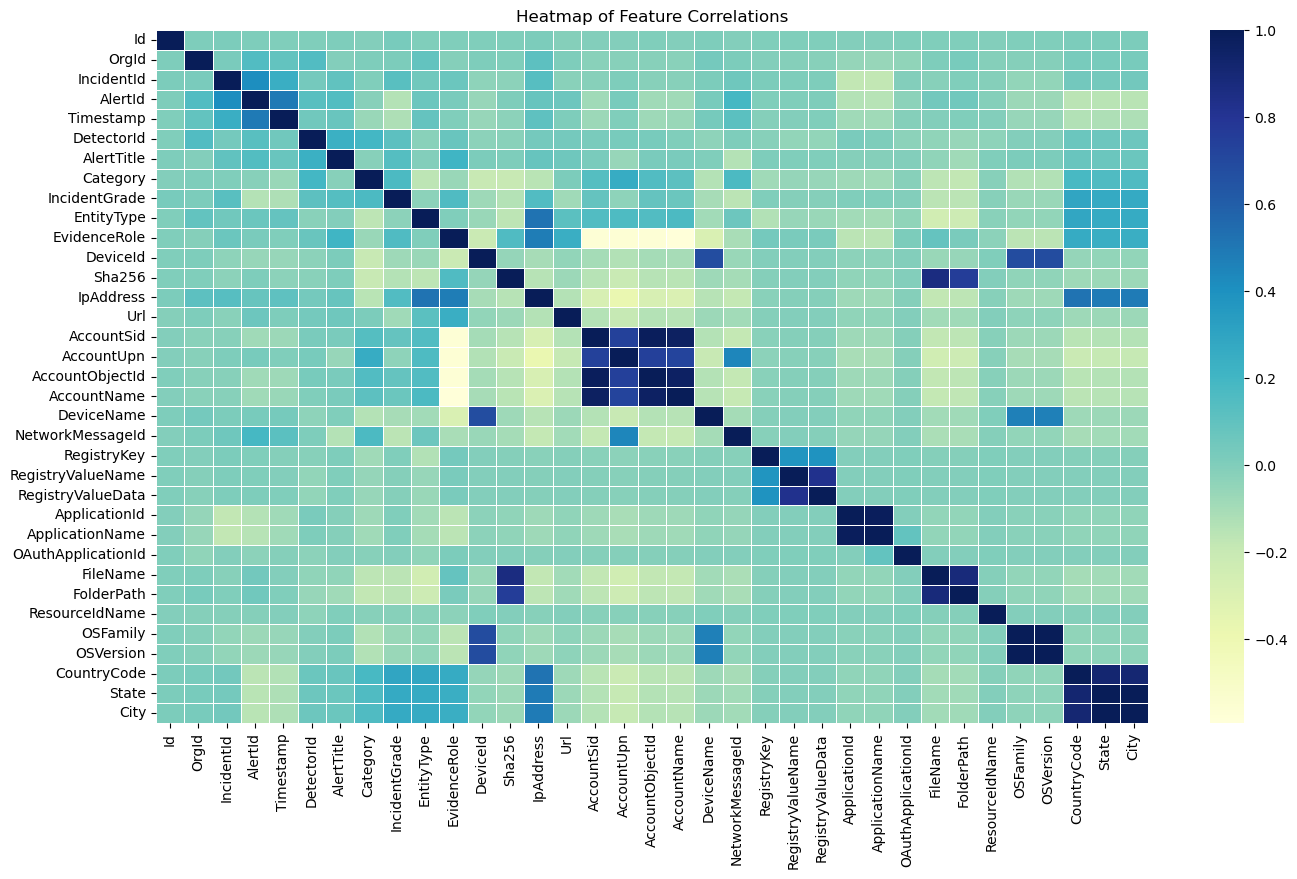

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 9))
corr = train_data.corr()
sns.heatmap(corr, cmap='YlGnBu', linewidths=0.5)
plt.title('Heatmap of Feature Correlations')
plt.show()

The heatmap shows correlations between features. The correlations across the diagonal are all dark blue, or 1, since features are perfectly correlated to themselves. Looking at other dark blue points, CountryCode, State, and City are all strongly correlated, which makes sense. FileName, Folderpath, and SHA256 (file hash) also have a strong correlation. The feature set can be simplified by removing features that are strongly correlated with eachother, but I will keep those features for now in case they potentially prove useful to models finding potentially non-linear relationships. The target feature IncidentGrade does not seem to have a strong correlation with any of the other features, so it is likely that a non-linear model will best accomodate this data.

Moving on, lets look at how balanced each class is:

In [11]:
print(train_data['IncidentGrade'].value_counts().sort_index())
print(test_data['IncidentGrade'].value_counts().sort_index())

IncidentGrade
0    3322713
1    2031967
2    4110817
Name: count, dtype: int64
IncidentGrade
0    1492354
1     902698
2    1752940
Name: count, dtype: int64


Each index corresponds to the following triage class:

0. TruePositive
1. FalsePositive
2. BenignPositive

Based on the above output, BenignPositive is the most prevalent class label, and FalsePositive is the least prevalent. There is not a substantial imbalance in the classes, which is good for when we want to create a model, as unbalanced data can severely effect a classification models performance.

We will soon start training some models, but first we will need to partition the feature set and the label column:

In [12]:
X_train = train_data.drop(columns=['IncidentGrade'])
Y_train = train_data['IncidentGrade']

X_test = test_data.drop(columns=['IncidentGrade'])
Y_test = test_data['IncidentGrade']

Here, X will be our feature set and Y will be the corresponding class labels.

### A Naive Approach: Logistic Regression

We will begin by creating a simple multinomial logistic regression model for the data. I do not expect the model to perform particulariy well since it is a linear model, but the training time is relatively fast and it should give us a solid starting point. We will start by normalizing the data as that will imporve model performance in this case.

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

from sklearn.linear_model import LogisticRegression

log_reg_model = LogisticRegression(
    solver='lbfgs',
    multi_class='multinomial',
    max_iter=1000
)

log_reg_model.fit(X_train_scaled, Y_train)

c:\Users\Asad\anaconda3\envs\tf_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=1000, multi_class='multinomial')

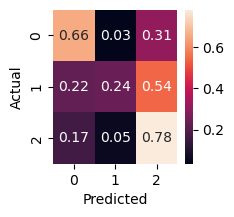

Test Accuracy: 0.619131859463567
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.66      0.66   1492354
           1       0.60      0.24      0.34    902698
           2       0.59      0.78      0.67   1752940

    accuracy                           0.62   4147992
   macro avg       0.62      0.56      0.56   4147992
weighted avg       0.62      0.62      0.60   4147992



In [33]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Display function for performance metrics
def show_performance(test, pred):
    cm = confusion_matrix(test, pred)
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(2,2))
    sns.heatmap(cmn, annot=True, fmt='.2f')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show(block=False)

    print("Test Accuracy:", accuracy_score(test, pred))
    print("Classification Report:\n", classification_report(test, pred))

Y_pred = log_reg_model.predict(X_test_scaled)
show_performance(Y_test, Y_pred)

As expected, the logisitc regression model did not perform particularily well, with an accuracy of 61.9%, it certainly performed significantly better than random chance but not good enough for a task like this where high accuracy is critical in ensuring that security threats are properly addressed. For a dataset like this, using a linear model will not be the best approach. A non-linear approach would be preffered, but due to the scale of the data and the tabular nature, a neural network may not be the best choice either. From the properties of the dataset, the best approach is likely to use some tree-based model, and there are quite a few to choose from.

### A Better Approach: Random Forest

Random Forest is a tree-based ensemble model that creates a series of decision trees from samples of the dataset and each decision node will operate on a subset of the features. The result is a forest of trees, each independantly trained on a random subset of data and features that each makes a vote for classification. This model is quite robust and effective for large tabular datasets and can model non-linear realtionships, so it should make for a better model. We will use the scikit-learn library as it has a built-in implementation for Random Forest.

In [22]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(
    n_estimators=500, # number of trees in forest
    max_depth=15,
    verbose=1,
    n_jobs=-1 # parameter to allow for maximum multithreading
    )
rf.fit(X_train, Y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 15.8min finished


RandomForestClassifier(max_depth=15, n_estimators=500, n_jobs=-1, verbose=1)

[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    4.4s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:   11.4s
[Parallel(n_jobs=24)]: Done 500 out of 500 | elapsed:   14.0s finished


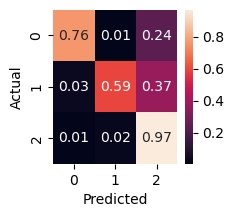

Accuracy: 0.8115124137172878
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.76      0.85   1492354
           1       0.92      0.59      0.72    902698
           2       0.71      0.97      0.82   1752940

    accuracy                           0.81   4147992
   macro avg       0.86      0.77      0.80   4147992
weighted avg       0.85      0.81      0.81   4147992



In [25]:
Y_pred = rf.predict(X_test)
show_performance(Y_test, Y_pred)

From the results above, we see that Random Forests has performed significantly better than logistic regression, achieving an accuracy of 81.2%. Looking at the confusion matrix, the model recall for the TruePositive class (0) is 76%, which is the most important class in this context since these indicate incidents that are true threats. The recall score is still a bit too low for an effective model. The other classes are not quite as important but it would be nice to improve the precision in those areas as well. Overall this model is fairly good but perhaps an alternative approach could do better.

### The Best Approach: Gradient Boosting
Gradient boosting is another tree-based ensemble model designed for classificartion tasks. The model sequentially builds decision trees where each tree corrects the errors of the previous one in a process called boosting. Gradient descent is used to minimize the errors of each previous ensemble of trees. While random forests builds trees independently, Gradient Boosting will build them sequentially, correcting errors as it goes. The approach usually has a longer training time, but there is a risk of overfitting if the parameters are not properly tuned. Below is the model I found worked best for the dataset after tweaking the parameters. The xgboost Python was selected for the task. Since this is a multi-class classification problem, the softmax objective function was the obvious pick.

In [27]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    enable_categorical=True,  
    tree_method='hist',
    objective='multi:softmax',
    num_class=3,    
    n_estimators=500,         
    max_depth=20,             
    verbosity=1,              
    n_jobs=-1,                
)
xgb_model.fit(X_train, Y_train)
print("Model training complete.")

Model training complete.


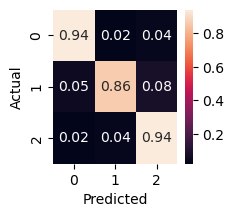

Accuracy: 0.9224629652130477
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94   1492354
           1       0.89      0.86      0.88    902698
           2       0.93      0.94      0.93   1752940

    accuracy                           0.92   4147992
   macro avg       0.92      0.91      0.92   4147992
weighted avg       0.92      0.92      0.92   4147992



In [ ]:
Y_pred = xgb_model.predict(X_test)
show_performance(Y_test, Y_pred)

The xgboost model has shown to be the best overall model by far with an accuracy of 92.2%, and a precision and recall of 94% for the TruePositive class. For security applications, a model this effective is preferable to the ones we trained previously, as it is able to identify 94% of the TruePositive report instances, with effective precision in the FalsePositive and BenignPositive classes as well. The Microsoft Publication referenced earlier created a model with an overall precision and recall of 87% and 86% respectively, so at the very least this model is an improvement to the model produced in the paper, since they used a Random Forest model. Overall, the xgboost model appears to be the best choice for this dataset, but there is one more model I want to train.

### Bonus Approach: Light Gradient Boosting

The Python library lightgbm provides a gradient boosting model that is optimized for training speed with accuracy comparable to xgboost, so I will test it out to see if a comparable or potentially better model can be produced. Since the training time will be significantly lower for this model, I can double the number of decision trees indicated in the n-estimators parameter, which could lead to improved model performance.

In [29]:
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier(n_estimators=1000, learning_rate=0.05, n_jobs=-1)
lgbm.fit(X_train, Y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.241632 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5805
[LightGBM] [Info] Number of data points in the train set: 9465497, number of used features: 34
[LightGBM] [Info] Start training from score -1.046872
[LightGBM] [Info] Start training from score -1.538649
[LightGBM] [Info] Start training from score -0.834032


LGBMClassifier(learning_rate=0.05, n_estimators=1000, n_jobs=-1)

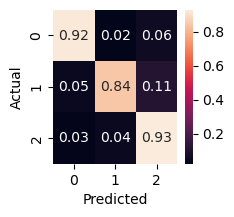

Accuracy: 0.9071295219470047
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93   1492354
           1       0.87      0.84      0.86    902698
           2       0.90      0.93      0.91   1752940

    accuracy                           0.91   4147992
   macro avg       0.90      0.90      0.90   4147992
weighted avg       0.91      0.91      0.91   4147992



In [30]:
Y_pred = lgbm.predict(X_test)
show_performance(Y_test, Y_pred)

With an overall accuracy of 90.7%, the lgboost model is only marginally worse than the xgboost model and was approximately 3 times faster at training. The performance of this model, while not the best, is still quite impressive given how quickly it was able to train an effective model.

### Conclusion
| Model        | Accuracy (%) |
|--------------|------------- |
| Logistic Regression| 61.9   |
| Random Forest      | 81.2   |
| XGB Classifier     |**92.2**|
| LGBM Classifier    | 90.7   |

Based on these final results, we were able to make a fairly effective model for this dataset using the XGB Classifier. The key insight for this project was recognizing that a good approach for a tabular, large, and non-linear dataset like this would be a tree-based model. While the model is fairly good, there is definately room for improvement. The data preprocessing could be more involved to transform certain key features, or the parameters for the XGB Classifier could be tweaked or pushed to their limits given more processing time and power, however for the scope of this project I believe the results above are sufficient. In the future, I may come back to these models to further tweak and improve them, but otherwise I will conclude the project here.
